# Training U-Net

### Load NPZ

In [1]:
import numpy as np
import sys
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

  
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label



def load_data():
    return np.load("X_promise.npy"), np.load("y_promise.npy")

In [3]:
# img_width, img_height, img_depth = 64, 128, 128

# input_shape = (img_width, img_height, img_depth, 1)

# X, y = load_data()
# X = np.asarray([x/x.max() for x in X])

img_width, img_height, img_depth = 8, 16, 16

input_shape = (img_width, img_height, img_depth, 1)

# Mock Data
X = np.random.uniform(size=(10, img_width, img_height, img_depth, 1))
y = np.random.uniform(size=(10, img_width, img_height, img_depth, 1)) > 0.5

In [13]:
X.shape, y.shape

((10, 8, 16, 16, 1), (10, 8, 16, 16, 1))

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [15]:
for d in [X_train, X_test, y_train, y_test]:
  print(d.shape, d.max())
  

(8, 8, 16, 16, 1) 0.9999249219004117
(2, 8, 16, 16, 1) 0.9998575329415246
(8, 8, 16, 16, 1) True
(2, 8, 16, 16, 1) True


## Augmentation

In [16]:
def cap_gen(x_batch, y_batch):
  while True:
      yield ([x_batch, y_batch], [y_batch, y_batch * x_batch])

train_cap_gen = cap_gen(X_train, y_train)

val_cap_gen = cap_gen(X_test, y_test)

In [17]:
import random
from skimage.io import imread, imshow, imread_collection, concatenate_images
import matplotlib.pyplot as plt

%matplotlib inline

for inp, out in train_cap_gen:
  break


In [18]:
np.asarray(inp).shape,np.asarray(out).shape

((2, 8, 8, 16, 16, 1), (2, 8, 8, 16, 16, 1))

/Users/dexterfichuk/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


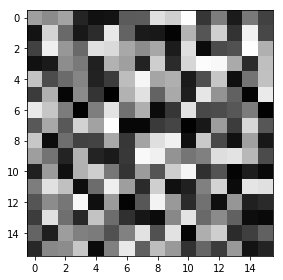

In [20]:
imshow(np.squeeze(inp[0][0][0]))

/Users/dexterfichuk/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


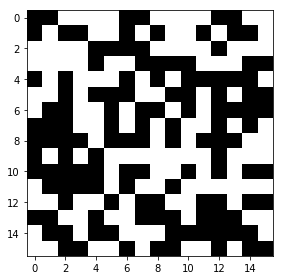

In [21]:
imshow(np.squeeze(out[0][0][0]))

In [22]:
inp[0].shape, out[0].shape

((8, 8, 16, 16, 1), (8, 8, 16, 16, 1))

In [25]:
%load_ext autoreload
%autoreload 2

from capsule_model import CapsNetBasic

train_model, eval_model, manipulate_model = CapsNetBasic((img_width, img_height, img_depth, 1), n_class=2)
train_model.summary()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Conv 1 Shape: (?, 8, 16, 16, 1)
Conv Reshaped Shape: (?, 8, 16, 16, 1, 1)
Num Capsule and num atom 8 32
Before Transpose (?, 8, 16, 16, 1, 1)
Transposed (1, ?, 8, 16, 16, 1)
Input sshape (6,)
Filter Shape (W) (5, 5, 5, 1, 256)
Tensor Reshaped (?, 8, 16, 16, 1)
Conv Shape (?, 8, 16, 16, 256)
Votes Shape (?, 1, 8, 16, 16, 8, 32)
Logit Shape (6,)
B shape (1, 1, 1, 8, 32)
Updating Routing
Votes Transposed (32, ?, 1, 8, 16, 16, 8)
Primary Caps (?, 8, 16, 16, 8, 32)
Num Capsule and num atom 1 16
Before Transpose (?, 8, 16, 16, 8, 32)
Transposed (8, ?, 8, 16, 16, 32)
Input sshape (6,)
Filter Shape (W) (1, 1, 1, 32, 16)
Tensor Reshaped (?, 8, 16, 16, 32)
Conv Shape (?, 8, 16, 16, 16)
Votes Shape (?, 8, 8, 16, 16, 1, 16)
Logit Shape (6,)
B shape (1, 1, 1, 1, 16)
Updating Routing
Votes Transposed (16, ?, 8, 8, 16, 16, 1)
Length call inuts shape (?, 8, 16, 16, 1, 16)
Squeezed length shape (?, 8, 16, 16, 16)
Ou

2D Summary
```
conv1 (None, 224, 224, 256)
reshape_50 (None, 224, 224, 1, 256)
primarycaps (None, 224, 224, 8, 32)
seg_caps (None, 224, 224, 1, 16)
input_45 (None, 224, 224, 1)
mask_29 (None, 224, 224, 1, 16)
reshape_51 (None, 224, 224, 16)
recon_1 (None, 224, 224, 64)
recon_2 (None, 224, 224, 128)
out_seg (None, 224, 224, 1)
out_recon (None, 224, 224, 1)
```

## CapsNet

In [28]:
from custom_losses import dice_hard, weighted_binary_crossentropy_loss, dice_loss, margin_loss
from keras.optimizers import Adam

def get_loss(net='caps', recon_wei=131.072, choice='dice', split=0, pos_class_weight = 4.167675853994922):
    
    if choice == 'w_bce':
        loss = weighted_binary_crossentropy_loss(pos_class_weight)
    elif choice == 'bce':
        loss = 'binary_crossentropy'
    elif choice == 'dice':
        loss = dice_loss
    elif choice == 'w_mar':
        loss = margin_loss(margin=0.4, downweight=0.5, pos_weight=pos_class_weight)
    elif choice == 'mar':
        loss = margin_loss(margin=0.4, downweight=0.5, pos_weight=1.0)
    else:
        raise Exception("Unknow loss_type")

    if net == 'caps':
        return {'out_seg': loss, 'out_recon': 'mse'}, {'out_seg': 1., 'out_recon': recon_wei}
    else:
        return loss, None

      
def compile_model(uncomp_model):
    # Set optimizer loss and metrics
    opt = Adam(lr=0.00005, beta_1=0.99, beta_2=0.999, decay=1e-6)
    metrics = {'out_seg': dice_hard}
#     metrics = {'out_seg': jaccard_coef}

    loss, loss_weighting = get_loss(choice='mar')
    
    uncomp_model.compile(optimizer=opt, loss=loss, metrics=metrics, loss_weights=loss_weighting)
    return uncomp_model
  


In [29]:
model = compile_model(uncomp_model=train_model, )

## Training

In [30]:
import numpy as np
# seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [31]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from time import time
import keras.backend as K
from google_drive_checkpoint import GoogleDriveCheckpoint

monitor_name = 'val_out_seg_dice_hard'
# monitor_name = 'val_out_seg_jaccard_coef'

earlystopper = EarlyStopping(monitor=monitor_name, min_delta=0, patience=25, verbose=0, mode='max')

model_name = "PROMISE2012-CapsSeg-{}".format(time())

# checkpointer = GoogleDriveCheckpoint(model_name + '.h5', drive, monitor=monitor_name, save_best_only=True, save_weights_only=True,
#                                        verbose=1, mode='max')
checkpointer = ModelCheckpoint(model_name + '.h5', monitor=monitor_name, save_best_only=True, save_weights_only=True,
                                       verbose=1, mode='max')

reduce_lr = ReduceLROnPlateau(monitor=monitor_name, factor=0.05, cooldown=0, patience=5, verbose=1, mode='max')

tb = TensorBoard(log_dir=os.path.join("log", model_name))

# sched = keras.callbacks.LearningRateScheduler(schedule, verbose=1)

callbacks = [
      earlystopper,
      checkpointer,
#       sched,
      reduce_lr,
      tb
]


In [ ]:
history = model.fit_generator(train_cap_gen, validation_data=val_cap_gen, 
                                      epochs=400, callbacks=callbacks, verbose = 1,
                                      shuffle = True,
                                      max_queue_size=40, workers=4, use_multiprocessing=False,
                                      steps_per_epoch=len(X_train)*5,
                                      validation_steps=len(X_test))

Epoch 1/400
13/40 [========>.....................] - ETA: 2:54 - loss: 21.8061 - out_seg_loss: 0.0540 - out_recon_loss: 0.1660 - out_seg_dice_hard: 0.6732